In [2]:
from scipy.special import comb

import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

from itertools import product

**Для начала реализуем функцию массы вероятности**

In [3]:
def ensemble_error(n, error):
    """
    Расчет вероятности ошибки ансамбля классификаторов с заданой вероятностью ошибки
    n - количество классификаторов
    error - вероятность ошибки каждого из классификаторов
    """
    k_start = math.ceil(n / 2.0)
    probs = [comb(n, k) * error ** k * (1 - error) ** (n - k)
             for k in range(k_start, n + 1)]
    return sum(probs)

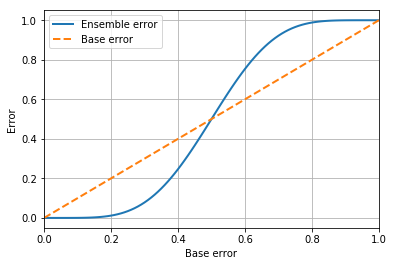

In [4]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(11, error) for error in error_range]

plt.plot(error_range, ens_errors,
         label='Ensemble error',
         linewidth=2)
plt.plot(error_range, error_range,
         linestyle='--', label='Base error',
         linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Error')
plt.xlim(0, 1)
plt.legend(loc='best')
plt.grid()
plt.show()

**Реализация классификатора на основе мажоритарного голосования**

In [17]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import _name_estimators
from sklearn.externals import six

import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    """ Ансамблевый классификатор на основе мажоритарного голосования
    
    Параметры
    ------
    classifiers : list
    Список классификаторов для ансамбля
    
    vote : str, {'classlabel', 'probability'}
    По умолчанию classlabel
    Если метка classlabel, то прогноз основывается на argmax меткок классов
    Если probability - argmax суммы вероятностей
    
    weights : list
    По умолчанию None
    Список весовых коэффициентов для классификаторов
    """
    
    def __init__(self, classifiers,
                 vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value 
                                  for key, value 
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        """
        Обучение классификаторов
        
        Параметры
        ------
        X : матрица обучающей выборки
        
        y : вектор целевых меток классов
        
        Возвращает
        ------
        self : объект
        """
        
        # Для уверенности в том, что метки классов начинаются с 0
        # что важно для argmax используем LabelEncoder
        
        self.label_encoder_ = LabelEncoder()
        self.label_encoder_.fit(y)
        self.classes_ = self.label_encoder_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.label_encoder_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        """
        Прогнозирование меток для X
        
        Параметры
        ------
        X : Матрица тренировочной выборки
        
        Возвращает 
        ------
        maj_vote : список спрогнозированных меток
        """
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:
                                           np.argmax(np.bincount(x, weights=self.weights)),
                                           axis=1,
                                           arr=predictions)
        
        maj_vote = self.label_encoder_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        """
        Прогнозирование вероятности принадлежности классу для X
        
        Параметры
        ------
        X : Матрица тренировочной выборки
        
        Возвращает 
        ------
        avg_proba : список вероятностей меток
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        """
        Получение параметров для grid search
        """
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep).items():
                    out[f'{name}__{key}'] = value
        return out

**Пример использования MajorityVoteClassifier**

In [22]:
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc

iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=.5,
                                                    random_state=1)

In [7]:
clf1 = LogisticRegression(solver='liblinear',
                          penalty='l2',
                          C=.001,
                          random_state=0)
clf2 = DecisionTreeClassifier(max_depth=3,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=2,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10 blocks cross validation')
for clf, label, in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC-AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

    


10 blocks cross validation
ROC-AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC-AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC-AUC: 0.93 (+/- 0.10) [KNN]


In [18]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority vote']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC-AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


ROC-AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC-AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC-AUC: 0.93 (+/- 0.10) [KNN]
ROC-AUC: 0.97 (+/- 0.10) [Majority vote]


**Оценка и настройка анасамбля**

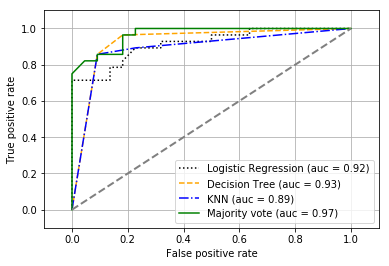

In [9]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, color, linestyle in zip(all_clf,
                                        clf_labels,
                                        colors,
                                        linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=color,
             linestyle=linestyle,
             label=f'{label} (auc = {roc_auc:.2f})')
plt.legend(loc='best')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-.1, 1.1])
plt.ylim([-.1, 1.1])
plt.grid()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

**Нарисуем области решений классификаторов**

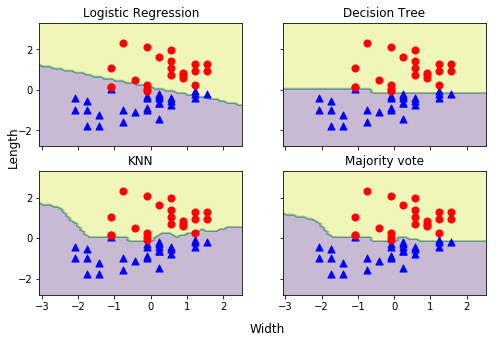

In [10]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))
fig, ax = plt.subplots(nrows=2, ncols=2,
                       sharex='col',
                       sharey='row',
                       figsize=(8, 5))
for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax[idx[0], idx[1]].contourf(xx, yy, Z, alpha=.3)
    ax[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0],
                               X_train_std[y_train == 0, 1],
                               c='blue', marker='^',
                               s=50)
    ax[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0],
                               X_train_std[y_train == 1, 1],
                               c='red', marker='o',
                               s=50)
    ax[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, s='Width', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Length', ha='center', va='center', fontsize=12, rotation=90)
plt.show()

In [21]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=0, solver='liblinear',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_param

In [27]:
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [.001, .1, 100.]}
grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc',
                    return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2'...',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')]])],
            vote='classlabel', weights=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'decisiontreeclassifier__max_depth': [1, 2], 'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [28]:
grid.cv_results_

{'mean_fit_time': array([0.00570116, 0.00426481, 0.00581591, 0.00397279, 0.00566599,
        0.00545211]),
 'std_fit_time': array([0.00144955, 0.00055769, 0.00150354, 0.00035351, 0.00153085,
        0.00101934]),
 'mean_score_time': array([0.0027528 , 0.00228994, 0.00282273, 0.0021769 , 0.00271432,
        0.00308788]),
 'std_score_time': array([0.00074218, 0.00038358, 0.00070788, 0.00020401, 0.00053745,
        0.00064688]),
 'param_decisiontreeclassifier__max_depth': masked_array(data=[1, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pipeline-1__clf__C': masked_array(data=[0.001, 0.1, 100.0, 0.001, 0.1, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'decisiontreeclassifier__max_depth': 1,
   'pipeline-1__clf__C': 0.001},
  {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1},
  {'decisiontr

In [31]:
for param, mean_score, std in zip(grid.cv_results_['params'],
                                  grid.cv_results_['mean_test_score'],
                                  grid.cv_results_['std_test_score']):
    print(f'{mean_score:.3f}+/-{std:.2f} {param}')

0.967+/-0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [35]:
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_:.2f}')

Best params: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Best score: 1.00
